In [1]:
# Set active directory to project root and configure logging
import os
import logging
from molecule.config import get_project_root_directory
ROOT_PATH = get_project_root_directory()
os.chdir(ROOT_PATH)
logging.basicConfig(level=logging.INFO)

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [3]:
from molecule.preprocess.feature_extraction import FeatureType
from molecule.preprocess.dataset import Dataset

INFO:rdkit:Enabling RDKit 2022.03.4 jupyter extensions


# Data and features imports

We import train and test datasets similarly to what we did previously.

In [4]:
dataset_train = Dataset("data/datasets/dataset_single_train.csv")
dataset_test = Dataset("data/datasets/dataset_single_test.csv")

This time, we will directly use the SMILE text representations to train a deep learning model. We still need to adopt some form of vectorized representation. The most straightforward one is to represent individual characters of the SMILE with one-hot encoding, so that a molecule is represented by a binary matrix of size (string_length, vocab_size).

We use 0-padding so that all samples in a dataset have the same length to be able to represent the features of a dataset as a rank 3 tensor.

The fact that samples in the train and test datasets may have different padded lengths will not be an issue because of the nature of models used.

In [5]:
X_train, y_train = dataset_train.get_features(FeatureType.SMILE), dataset_train.labels
X_test, y_test = dataset_test.get_features(FeatureType.SMILE), dataset_test.labels
print(f"Size of training features: {X_train.shape}")
print(f"Size of test features: {X_test.shape}")

Size of training features: (3999, 74, 29)
Size of test features: (1000, 68, 29)


# Baselines

## Naive Bayes

In [6]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

Let's compute basic features from the SMILE representation, for instance the presence of a character or its number of occurences.

In [7]:
# number of occurences per character for each sample
X_train_character_count = X_train.sum(axis=1)
X_test_character_count = X_test.sum(axis=1)

In [8]:
# whether a char is present at least once for each sample
X_train_character_presence = X_train_character_count > 0
X_test_character_presence = X_test_character_count > 0

We can try to use a first naive bayes model based on the presence of a character in the SMILE representation.

In [9]:
naive_bayes_clf = BernoulliNB(binarize=None)
naive_bayes_clf.fit(X_train_character_presence, y_train)

BernoulliNB(binarize=None)

In [10]:
predicted_proba = naive_bayes_clf.predict_proba(X_test_character_presence)[:,1]

In [11]:
auc = roc_auc_score(y_test, predicted_proba)
print(f"AUC: {auc:.3f}")

AUC: 0.666


The AUC is a bit lower than that of the models using Morgan fingerprints. This is not surprising, as the presence 
or absence of a character in the SMILE representation is a very basic feature.

Let's try a model based on the character count instead, for insteance a naive bayes based on a multinomial distribution.

In [12]:
multinomial_clf = MultinomialNB()
multinomial_clf.fit(X_train_character_count, y_train)

MultinomialNB()

In [13]:
predicted_proba = multinomial_clf.predict_proba(X_test_character_count)[:,1]
auc = roc_auc_score(y_test, predicted_proba)
print(f"AUC: {auc:.3f}")

AUC: 0.724


We have achieved performance as good as the one we obtained previously with the Morgan fingerprints, using very basic features and model. This suggests that Morgan fingerprints may not be the best features for our classification task.

## Random forest

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Let's get a second, ideally better baseline based on this feature, leveraging potentially non-linear relations between the features and the target. We can use a random forest again.

In [15]:
%%time
hyperparameters = {"max_depth": [2, 5, 10, 20]}
random_forest_clf = GridSearchCV(RandomForestClassifier(random_state=42),
            hyperparameters, scoring="roc_auc")
random_forest_clf.fit(X_train_character_count, y_train)

CPU times: user 4.3 s, sys: 7.18 ms, total: 4.31 s
Wall time: 4.31 s


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 5, 10, 20]}, scoring='roc_auc')

In [16]:
aucs = random_forest_clf.cv_results_["mean_test_score"]
print(f"Cross validation AUCs: {aucs}")

Cross validation AUCs: [0.69085066 0.71217278 0.72318229 0.70489049]


Let's make predictions with the best hyperparameters (max_depth=10) with the model trained on the full training set.

In [17]:
predicted_proba = random_forest_clf.predict_proba(X_test_character_count)[:,1]

In [18]:
auc = roc_auc_score(y_test, predicted_proba)
print(f"AUC on test set: {auc:.3f}")

AUC on test set: 0.739


This is a little bit but not drastically better than the results obtained with the multinomial naive bayes. This may be due to intrinsic limitations in the features we used.

Similarly, a LightGBM approach was also trained on these features. Results were not significantly better.

# Deep learning

In [19]:
from sklearn.metrics import (
    classification_report, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)
from torch.utils.tensorboard import SummaryWriter

In [21]:
from molecule.train.model import Model
from molecule.preprocess.feature_extraction import FeatureType
import utils

A deep learning model may be able to learn subtle relationships between the input text and the target. Since the text is a sequence of characters of variable length, a recurrent neural network may be well-suited for this task. Specifically, we will use a multilayer GRU.

Here is a general overview of the network:

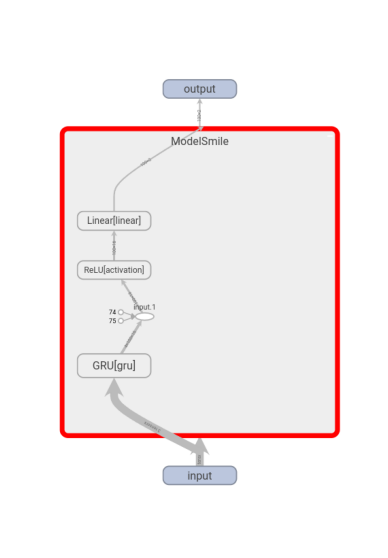

In [28]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(plt.imread("data/images/DNN2.png"))
plt.show()

The specific architecture is available in molecule.train.deep_architectures.ModelSmile

## Training

In [29]:
model = Model(FeatureType.SMILE)

INFO:root:Using CUDA for training and inference.


Let's train the model using the default training parameters defined in the architecture module. We monitor the evolution of the training and validation losses, as well as the validation AUC.

**WARNING**: it is ***very strongly*** advised to have a GPU to train the model. Otherwise, you can load a pre-trained model using the provided functions and pre-trained models.

In [30]:
train_losses, val_losses, val_aucs = model.fit(X_train, y_train, validation_set_ratio=0.2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.89it/s]


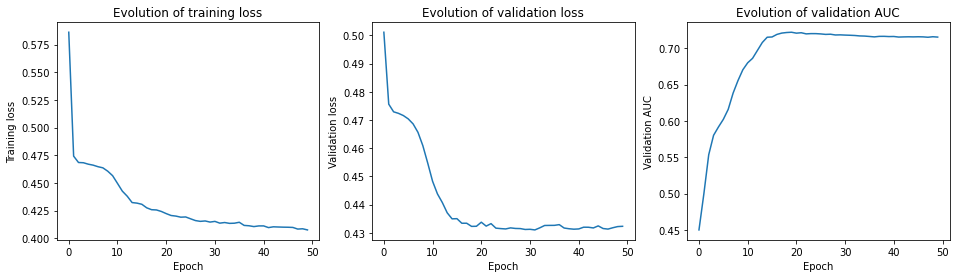

In [31]:
utils.plot_training_curves(train_losses, val_losses, val_aucs)

Note: the validation loss and AUC tended to increase if training continued for more than 15 epochs, so early stopping was used.

## Performance evaluation

In [32]:
predicted_proba = model.predict_proba(X_test)

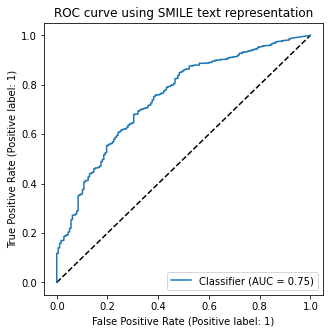

In [33]:
fig = plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], "--k");plt.title("ROC curve using SMILE text representation")
RocCurveDisplay.from_predictions(y_test, predicted_proba, ax=fig.axes[0])
plt.show()

We obtain performance a bit higher than the approach using Morgan fingerprints.

Let's have a look at the Precision-Recall curve:

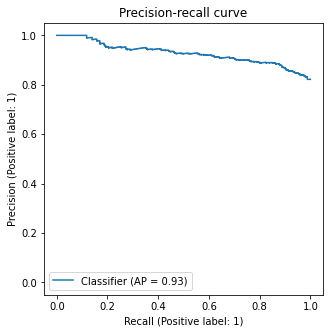

In [36]:
fig = plt.figure(figsize=(5,5))
plt.ylim([-.05,1.05]);plt.title("Precision-recall curve")
PrecisionRecallDisplay.from_predictions(y_test, predicted_proba, ax=fig.axes[0])
plt.show()

Performance is also slightly higher.

We can once again measure performance with a high decision threshold (with a threshold of 0.5, the model always predicts 1 similarly to previously).

In [37]:
predicted_class = model.predict(X_test, decision_threshold=0.95)

In [38]:
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.19      1.00      0.32       178
           1       1.00      0.08      0.15       822

    accuracy                           0.24      1000
   macro avg       0.60      0.54      0.23      1000
weighted avg       0.86      0.24      0.18      1000



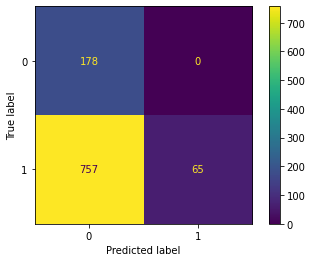

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, predicted_class);

This time, all the samples predicted as "positive" are indeed positive. The difference may not be statistically significant though.

**Possible improvements:**
- Improve the model architecture (for instance, use transformers, which enable to get very impressive results on language tasks with enough data).
- Instead of one-hot encoding, learn dense representations for molecule components by training an embedding on a different task with more data (use transfer learning similarly to word embeddings).
- Investigate completely different feature representations. For instance, graph-CNNs seem to be able to obtain good performance in molecule property predictions when applied to graph molecular structures.